# Sprint 2 Project

### Creating your own recommender engine pool and generating recommendations from a seed track

*A. Individual*
1. Choose your own set of genres to be used as prediction values of the KNN model. You may select among the ones listed above or a completely new one (but you must already have the scraped playlist and tracks data for this new genre) 

2. Choose the features you want to use for the classification. Start by using all and then narrow down by removing one feature at a time and checking if the accuracy increases.

3. Check if the model works by using it to predict genres of the spotify_daily_charts_tracks dataset. Do some spot checks and view the songs classified with the highest probabilities per genre


*B. Groupwork: For your sprint project*

4. Obtain a tracks dataset that is relevant to the client you are targeting. 
   For example:
   
    - A client artist's full discography (hint: use sp.playlist_tracks(ALBUM_ID) for every album of the artist)
    
    - Tracks from a popular playlist in spotify that your client artist appears in
    
    - Discographies of prospect artists to collaborate with 
    
    - Popular tracks of the genre that your client artist is targeting to enter
    
    
5. Using the model you tuned in (A), predict the genres of the tracks in (B.4). 

6. Do some spot checks and view the songs classified with the highest probabilities per genre. 
   What does the predicted classifications reveal about your tracks dataset?
   
*C. Groupwork: For your sprint project*

7. Explore different seed tracks configurations:
    - A single track
    - A *representative track* made by aggregating the audio features and genre probabilities of all tracks in a chosen album/genre
    - A *hypothetical track* with specified desired audio feature values
    
8. For each choice of seed track in, generate using the recommender engine pool you made in (A). As a user, would you listen to the recommended tracks?

9. In addition to (2), check if the top 10 tracks with the **worst** similarity measure (i.e. most dissimilar to the seed track) make sense. As a user, do you agree that these are the tracks to be first discarded from the recommendation pool?



In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score,roc_curve, auc, confusion_matrix, classification_report
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_similarity

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

%matplotlib inline

## Part 1. Recommender Engine Pool

### 1. Read the training data

In [2]:
#genre_names = ["R&B", "Classical", "Country", "Electronic", "Hiphop","Jazz", "Pop", "Rock", "Reggae", "Rap"]
genre_names = ["Rap","Rock","Jazz","EDM"]

playlist_df_list = []
track_df_list = []
for genre in genre_names:
    # read and process the playlist data for keyword
    print(genre)
    pdf = pd.read_csv('data/'+genre.lower()+'_playlist_data.csv')
    pdf['genre'] = genre.lower().replace('&','n')
    playlist_df_list.append(pdf)

    tdf = pd.read_csv('data/'+genre.lower()+'_playlist_tracks_data.csv')
    tdf['genre'] = genre.lower().replace('&','n')
    tdf = tdf.drop(columns=['playlist_name'])
    tdf = tdf.merge(pdf[['playlist_id','playlist_name']], on=['playlist_id'], how='left')
    
    track_df_list.append(tdf)
    
    
        
playlist_df = pd.concat(playlist_df_list)
tracks_df = pd.concat(track_df_list)


Rap
Rock
Jazz
EDM


In [3]:
tracks_df['genre'].value_counts()

edm     2386
jazz    1746
rock    1605
rap     1318
Name: genre, dtype: int64

In [4]:
#tracks_df[tracks_df['genre']=='edm']

In [5]:
#check columns
print("Playlist dataset columns: %s \n" % playlist_df.columns.values)
print("Tracks dataset columns: %s" % tracks_df.columns.values)

Playlist dataset columns: ['playlist_id' 'playlist_name' 'playlist_total_tracks' 'owner_id'
 'owner_name' 'total_followers' 'genre'] 

Tracks dataset columns: ['track_id' 'track_name' 'artist_id' 'artist_name' 'album_id' 'duration'
 'release_date' 'popularity' 'danceability' 'energy' 'key' 'loudness'
 'mode' 'speechiness' 'acousticness' 'instrumentalness' 'liveness'
 'valence' 'tempo' 'playlist_id' 'genre' 'playlist_name']


In [6]:
#check null rows
#playlist_df[playlist_df.isnull().any(1)]
#tracks_df[tracks_df.isnull().any(1)]


In [7]:
#remove null rows
#tracks_df = tracks_df[~tracks_df.isnull().any(1)]


In [8]:
#retain only distinct tracks per keyword
tracks_df =tracks_df.drop_duplicates(subset='track_id')


In [9]:
#tally of tracks
#tracks_df['genre'].value_counts()
tracks_df['genre'].value_counts(normalize=True)

edm     0.346098
jazz    0.240644
rock    0.222077
rap     0.191181
Name: genre, dtype: float64

### 2. Refine the training data

In [10]:
#get top 5 playlists per genre
top_playlists_df = playlist_df.groupby('genre').head(5)
top_playlists_df

,playlist_id,playlist_name,playlist_total_tracks,owner_id,owner_name,total_followers,genre
0,37i9dQZF1DX0XUsuxWHRQd,RapCaviar,50,spotify,Spotify,13588683,rap
1,37i9dQZF1DX76t638V6CA8,Rap Workout,59,spotify,Spotify,1263588,rap
2,37i9dQZF1DWSIvbYYt1Dvi,RAPública,60,spotify,Spotify,993985,rap
3,37i9dQZF1DX8Kgdykz6OKj,Jazz Rap,100,spotify,Spotify,771168,rap
4,37i9dQZF1DX6PKX5dyBKeq,Rap UK,81,spotify,Spotify,718436,rap
0,37i9dQZF1DWXRqgorJj26U,Rock Classics,145,spotify,Spotify,8713321,rock
1,37i9dQZF1DXcF6B6QPhFDv,Rock This,50,spotify,Spotify,4490497,rock
2,37i9dQZF1DX1rVvRgjX59F,90s Rock Anthems,150,spotify,Spotify,4091838,rock
3,37i9dQZF1DWYN0zdqzbEwl,Rock en Español,60,spotify,Spotify,3825910,rock
4,37i9dQZF1DX6xOPeSOGone,Soft Rock,100,spotify,Spotify,2801391,rock


In [11]:
#tracks_df = tracks_df[tracks_df['playlist_id'].isin(top_playlists_df['playlist_id'].values)]
tracks_df['genre'].value_counts()

edm     2386
jazz    1659
rock    1531
rap     1318
Name: genre, dtype: int64

In [12]:
tracks_df.columns

Index(['track_id', 'track_name', 'artist_id', 'artist_name', 'album_id',
       'duration', 'release_date', 'popularity', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'playlist_id',
       'genre', 'playlist_name'],
      dtype='object')

### 3. Feature Engineering

##### Conversions/Normalizations

In [13]:
#convert duration from ms to mins
tracks_df['duration_mins']=tracks_df['duration']/60000

In [14]:


tracks_df['loudness'] = scaler.fit_transform(tracks_df[['loudness']])
tracks_df['loudness'].describe()


count    6894.000000
mean        0.761291
std         0.129900
min         0.000000
25%         0.718079
50%         0.800682
75%         0.848272
max         1.000000
Name: loudness, dtype: float64

In [15]:
#Normalize tempo
tracks_df['tempo'] =  scaler.fit_transform(tracks_df[['tempo']])
#check
tracks_df['tempo'].describe()


count    6894.000000
mean        0.543628
std         0.124587
min         0.000000
25%         0.447551
50%         0.554886
75%         0.609126
max         1.000000
Name: tempo, dtype: float64

###### Categorical Encoding

In [16]:
tracks_df["genre"] = tracks_df["genre"].astype('category')
tracks_df.dtypes

track_id              object
track_name            object
artist_id             object
artist_name           object
album_id              object
duration               int64
release_date          object
popularity             int64
danceability         float64
energy               float64
key                    int64
loudness             float64
mode                   int64
speechiness          float64
acousticness         float64
instrumentalness     float64
liveness             float64
valence              float64
tempo                float64
playlist_id           object
genre               category
playlist_name         object
duration_mins        float64
dtype: object

In [17]:
tracks_df['genre'].value_counts()

edm     2386
jazz    1659
rock    1531
rap     1318
Name: genre, dtype: int64

In [18]:
tracks_df['genre_id'] = tracks_df["genre"].cat.codes
tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,playlist_id,genre,playlist_name,duration_mins,genre_id
0,7o4gBbTM6UBLkOYPw9xMCz,Moonwalking in Calabasas (feat. Blueface) - Remix,0WK3H9OErSn5zKOkOV5egm,DDG,1z02WpEdAuImwfySk43owY,170232,2020-12-02,84,0.928,0.341,...,0.0614,0.0,0.1620,0.745,0.590706,37i9dQZF1DX0XUsuxWHRQd,rap,RapCaviar,2.837200,2
1,5vGLcdRuSbUhD8ScwsGSdA,Whoopty,7arQA31aZVS8yS6zUveWzb,CJ,5oBYG6dEI2Er6EeLnmonGE,123428,2020-08-20,95,0.711,0.598,...,0.1900,0.0,0.1500,0.737,0.637107,37i9dQZF1DX0XUsuxWHRQd,rap,RapCaviar,2.057133,2
2,26UxwWl9xCb83OynXELJcL,Masterpiece,4r63FhuTkUYltbVAg5TQnk,DaBaby,6kaYDcX9dNmJE5OU71IUby,181714,2021-01-15,74,0.781,0.726,...,0.0299,0.0,0.0930,0.436,0.636257,37i9dQZF1DX0XUsuxWHRQd,rap,RapCaviar,3.028567,2
3,0k7wmahjkn389wAZdz19Cv,Drankin N Smokin,1RyvyyTE3xzB2ZywiAwp0i,Future,48xpWR8K6CGpy3ETAym3pt,213520,2020-11-13,84,0.752,0.658,...,0.0421,0.0,0.0927,0.387,0.690630,37i9dQZF1DX0XUsuxWHRQd,rap,RapCaviar,3.558667,2
4,4DuUwzP4ALMqpquHU0ltAB,Tyler Herro,2LIk90788K0zvyj2JJVwkJ,Jack Harlow,4Vd7lpztpJdmMt9hrLfXWe,156497,2020-10-22,87,0.794,0.756,...,0.1100,0.0,0.2470,0.775,0.559345,37i9dQZF1DX0XUsuxWHRQd,rap,RapCaviar,2.608283,2


In [19]:
genre_lookup = dict(tracks_df.groupby('genre_id').head(1)[['genre_id','genre']].values)
genre_lookup

{2: 'rap', 3: 'rock', 1: 'jazz', 0: 'edm'}

## 4. Train a KNN model

Tuning the model


Tuning kNN classification model with K-Fold=4...
Shape of X_Train:(5515, 9)
Shape of y_Train:(5515,)
Shape of X_Test:(1379, 9)
Shape of y_Test:(1379,)
Finding best k...


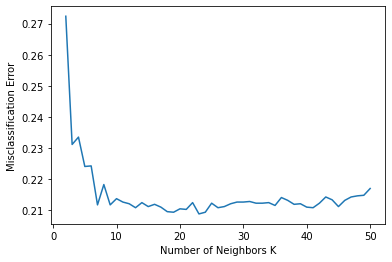

The optimal number of neighbors is 23 with score 79%

Tuning kNN classification model with K-Fold=5...
Shape of X_Train:(5515, 9)
Shape of y_Train:(5515,)
Shape of X_Test:(1379, 9)
Shape of y_Test:(1379,)
Finding best k...


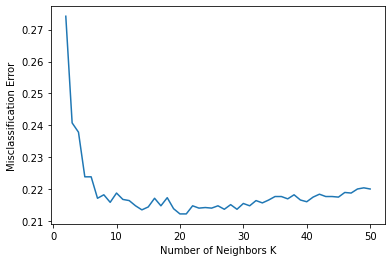

The optimal number of neighbors is 20 with score 78%

Tuning kNN classification model with K-Fold=8...
Shape of X_Train:(5515, 9)
Shape of y_Train:(5515,)
Shape of X_Test:(1379, 9)
Shape of y_Test:(1379,)
Finding best k...


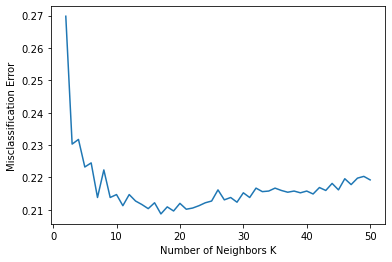

The optimal number of neighbors is 17 with score 79%

Tuning kNN classification model with K-Fold=10...
Shape of X_Train:(5515, 9)
Shape of y_Train:(5515,)
Shape of X_Test:(1379, 9)
Shape of y_Test:(1379,)
Finding best k...


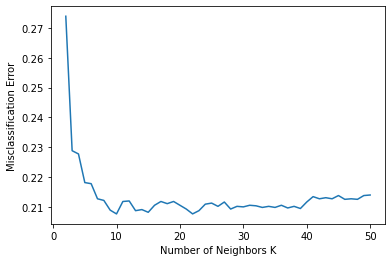

The optimal number of neighbors is 10 with score 79%


In [20]:
#Select audio features to use for the model
feature_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',\
                 'liveness', 'valence', 'tempo']
#feature_cols = ['energy', 'loudness', 'speechiness']
results_optimal_k = []

kfolds= [4,5,8,10]

for d in kfolds:
    print('\nTuning kNN classification model with K-Fold=%d...' % d)
    # create feature matrix (X)
    X = tracks_df[feature_cols]
    y = tracks_df['genre_id']

    # creating training set, test set and checking shapes 
    X_train,X_test,Y_train,Y_test = train_test_split(X,y, test_size=0.2)
    print("Shape of X_Train:"+str(X_train.shape))
    print("Shape of y_Train:"+str(Y_train.shape))
    print("Shape of X_Test:"+str(X_test.shape))
    print("Shape of y_Test:"+str(Y_test.shape))
    
    #train model
    cv_scores = []
    neighbors=np.arange(2,51)
    print('Finding best k...')
    
    #Perform KNN using K= [1..50] and validate using k-fold k = 5
    for k in neighbors:
        #print('Fitting for k=%d' % k)
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_train, Y_train, cv=d)#, scoring='accuracy')
        cv_scores.append(scores.mean())
        
    # changeto misclassification error
    mse = [1 - x for x in cv_scores]

    # determining best k
    optimal_k = neighbors[mse.index(min(mse))]
    results_optimal_k.append(optimal_k)
    
    knn_optimal = KNeighborsClassifier(n_neighbors=k)
    knn_optimal.fit(X, y)
    # plot misclassification error vs k
    plt.plot(neighbors, mse)
    plt.xlabel("Number of Neighbors K")
    plt.ylabel("Misclassification Error")
    plt.show()
    
    print("The optimal number of neighbors is %d with score %d%%" % (optimal_k, 100*(1-min(mse))))


In [21]:
#results_optimal_k = [38, 33, 17, 21, 13, 46, 26, 27, 10, 26]
results_optimal_k

[23, 20, 17, 10]

### 5. Model Prediction

In [22]:
#Predict genres of the charting tracks
chart_tracks_df = pd.read_csv("data/spotify_daily_charts_tracks.csv")
chart_tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0kN8xEmgMW9mh7UmDYHlJP,Versace on the Floor,0du5cEVh5yTK9QJze8zA0C,Bruno Mars,4PgleR09JVnm3zY1fW3XBA,261240,2016-11-17,76,0.578,0.574,2.0,-6.209,1.0,0.0454,0.196,0.00000,0.0830,0.301,174.152
1,5uCax9HTNlzGybIStD3vDh,Say You Won't Let Go,4IWBUUAFIplrNtaOHcJPRM,James Arthur,7oiJYvEJHsmYtrgviAVIBD,211466,2016-10-28,85,0.358,0.557,10.0,-7.398,1.0,0.0590,0.695,0.00000,0.0902,0.494,85.043
2,7BKLCZ1jbUBVqRi2FVlTVw,Closer,69GGBxA162lTqCwzJG5jLp,The Chainsmokers,0rSLgV8p5FzfnqlEk4GzxE,244960,2016-07-29,85,0.748,0.524,8.0,-5.599,1.0,0.0338,0.414,0.00000,0.1110,0.661,95.010
3,2rizacJSyD9S1IQUxUxnsK,All We Know,69GGBxA162lTqCwzJG5jLp,The Chainsmokers,0xmaV6EtJ4M3ebZUPRnhyb,194080,2016-09-29,69,0.662,0.586,0.0,-8.821,1.0,0.0307,0.097,0.00272,0.1150,0.296,90.000
4,5MFzQMkrl1FOOng9tq6R9r,Don't Wanna Know,04gDigrS5kc9YWfZHwBETP,Maroon 5,0fvTn3WXF39kQs9i3bnNpP,214480,2016-10-11,0,0.783,0.623,7.0,-6.126,1.0,0.0800,0.338,0.00000,0.0975,0.447,100.048


In [23]:
#normalize loudness and tempo
chart_tracks_df['loudness'] = scaler.fit_transform(chart_tracks_df[['loudness']])
chart_tracks_df['tempo'] =  scaler.fit_transform(chart_tracks_df[['tempo']])

Test the model with external data by predicting the genres of the spotify charting tracks!

In [24]:
#Predict genres of the spotify charts
feature_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',\
                 'liveness', 'valence', 'tempo']
#feature_cols = ['energy', 'loudness', 'tempo']
genres = [genre_lookup[i] for i in np.arange(len(genre_names))]

n=3 #pick kfold=10
print("Predicting with optimal k: %d" %(results_optimal_k[n]))

knn_optimal = KNeighborsClassifier(n_neighbors=results_optimal_k[n])
X = tracks_df[feature_cols]
y = tracks_df['genre_id']
knn_optimal.fit(X, y)

chart_tracks_df = chart_tracks_df.dropna()
chart_tracks_df['predicted_genre_id'] = chart_tracks_df.apply(lambda x:  knn_optimal.predict(x[feature_cols].values.reshape(1,-1))[0]\
                                               , axis=1)
chart_tracks_df['predicted_genre'] = chart_tracks_df['predicted_genre_id'].apply(lambda x: genre_lookup[x])
chart_tracks_df['predicted_genre_prob'] = chart_tracks_df.apply(lambda x:  np.max(knn_optimal.predict_proba(x[feature_cols].values.reshape(1,-1)))\
                                                    , axis=1)
chart_tracks_df['all_genre_prob'] = chart_tracks_df.apply(lambda x:  knn_optimal.predict_proba(x[feature_cols].values.reshape(1,-1))[0]\
                                                    , axis=1)


Predicting with optimal k: 10


In [25]:
#explode genre probabilities into separate columns
charts_predicted_genre_prob = pd.DataFrame(chart_tracks_df["all_genre_prob"].to_list(),
                                           columns=['predicted_'+g+'_prob' for g in genres])
charts_predicted_genre_prob['track_id'] = chart_tracks_df['track_id']
chart_tracks_df = pd.merge(chart_tracks_df,charts_predicted_genre_prob, how='left', on='track_id')
chart_tracks_df = chart_tracks_df.drop(columns='all_genre_prob')
chart_tracks_df = chart_tracks_df.sort_values('predicted_genre_prob', ascending=False)
chart_tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,liveness,valence,tempo,predicted_genre_id,predicted_genre,predicted_genre_prob,predicted_edm_prob,predicted_jazz_prob,predicted_rap_prob,predicted_rock_prob
376,6CfrYuD3YRDYdYvH9jNtXY,No Long Talk,3TVXtAsR1Inumwj472S9r4,Drake,1lXY618HWkwYKJWBRYR4MK,149568,2017-03-18,60,0.913,0.6080,...,0.533,0.578,0.273760,2,rap,1.0,0.0,0.0,1.0,0.0
1158,4hEcAsNF6RG9VCV7xElgCG,You Are My Sunshine,0rZRTXEmmPmx6gt92tBqIc,Moira Dela Torre,05rQadwAVYTpNNnBoeTuj0,164320,2018-02-19,56,0.492,0.2350,...,0.179,0.362,0.401746,1,jazz,1.0,0.3,0.1,0.1,0.5
1607,2jt2WxXMCD4zjACthkJQVE,The Ringer,7dGJo4pcD2V6oG8kP0tJRR,Eminem,3HNnxK7NgLXbDoxRZxNWiR,337941,2018-08-31,69,0.939,0.5510,...,0.192,0.420,0.405986,2,rap,1.0,0.1,0.0,0.5,0.4
1595,7uuEfUMuPeQ7RlSWa0cES2,Can’t Help Falling in Love,7h4j9YTJJuAHzLCc3KCvYu,Kina Grannis,32BVrPjwweOQcHKKpxgE4l,201933,2018-08-10,0,0.266,0.0596,...,0.132,0.143,0.794792,1,jazz,1.0,0.0,0.4,0.0,0.6
2274,19AlSgwI1midC2PU1TDkeF,Pekeng Kaibigan,1vcXQE9gZOF9PCAtdtT51L,Geo Ong,3A5uVKYCA9EJ6AIIIvHvdc,249085,2019-02-11,47,0.953,0.5800,...,0.108,0.765,0.452165,2,rap,1.0,0.8,0.0,0.1,0.1


Check out tracks with highest assigned probability

In [26]:
chart_tracks_df.groupby('predicted_genre_id').head()[['artist_name','track_name','predicted_genre','predicted_genre_prob']]

,artist_name,track_name,predicted_genre,predicted_genre_prob
376,Drake,No Long Talk,rap,1.0
1158,Moira Dela Torre,You Are My Sunshine,jazz,1.0
1607,Eminem,The Ringer,rap,1.0
1595,Kina Grannis,Can’t Help Falling in Love,jazz,1.0
2274,Geo Ong,Pekeng Kaibigan,rap,1.0
1155,Moira Dela Torre,Torete,rock,1.0
1156,Moira Dela Torre,Tagpuan,jazz,1.0
1590,BTS,DNA (Pedal 2 LA Mix),rock,1.0
1000,Gary Valenciano,Pasko Na Sinta Ko,jazz,1.0
2681,Jeremy Zucker,"always, i'll care",jazz,1.0


View histogram of predicted genre probabilities

<AxesSubplot:>

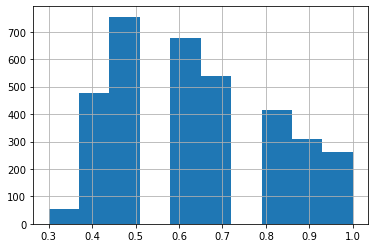

In [27]:
chart_tracks_df['predicted_genre_prob'].hist()

Check out tally of predicted genres

In [28]:
chart_tracks_df['predicted_genre'].value_counts()

rap     1169
rock     934
edm      840
jazz     546
Name: predicted_genre, dtype: int64

>Q **Spot Check**: Check out a song you're familiar with and see if the predicted genres and probabilities makes sense

In [29]:
this_song = 'SONG NAME HERE'
chart_tracks_df[chart_tracks_df['track_name']=='What is Love']

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,liveness,valence,tempo,predicted_genre_id,predicted_genre,predicted_genre_prob,predicted_edm_prob,predicted_jazz_prob,predicted_rap_prob,predicted_rock_prob
2786,1IX47gefluXmKX4PrTBCRM,What is Love,7n2Ycct7Beij7Dj7meI4X0,TWICE,35LVzMbjGUCfYZYEP6YWyr,208240,2018-07-09,46,0.574,0.909,...,0.264,0.565,0.722332,3,rock,0.6,0.4,0.1,0.4,0.1


In [30]:
#save data
chart_tracks_df.to_csv("data/spotify_daily_charts_tracks_predicted_genres.csv", index=False, encoding='utf-8')

## Part 2. Recommender Engine

In [31]:
#read data
chart_tracks_df=pd.read_csv("data/spotify_daily_charts_tracks_predicted_genres.csv")
#normalize loudness and tempo
scaler = MinMaxScaler()
chart_tracks_df['loudness'] = scaler.fit_transform(chart_tracks_df[['loudness']])
chart_tracks_df['tempo'] =  scaler.fit_transform(chart_tracks_df[['tempo']])
chart_tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,liveness,valence,tempo,predicted_genre_id,predicted_genre,predicted_genre_prob,predicted_edm_prob,predicted_jazz_prob,predicted_rap_prob,predicted_rock_prob
0,6CfrYuD3YRDYdYvH9jNtXY,No Long Talk,3TVXtAsR1Inumwj472S9r4,Drake,1lXY618HWkwYKJWBRYR4MK,149568,2017-03-18,60,0.913,0.6080,...,0.533,0.578,0.273760,2,rap,1.0,0.0,0.0,1.0,0.0
1,4hEcAsNF6RG9VCV7xElgCG,You Are My Sunshine,0rZRTXEmmPmx6gt92tBqIc,Moira Dela Torre,05rQadwAVYTpNNnBoeTuj0,164320,2018-02-19,56,0.492,0.2350,...,0.179,0.362,0.401746,1,jazz,1.0,0.3,0.1,0.1,0.5
2,2jt2WxXMCD4zjACthkJQVE,The Ringer,7dGJo4pcD2V6oG8kP0tJRR,Eminem,3HNnxK7NgLXbDoxRZxNWiR,337941,2018-08-31,69,0.939,0.5510,...,0.192,0.420,0.405986,2,rap,1.0,0.1,0.0,0.5,0.4
3,7uuEfUMuPeQ7RlSWa0cES2,Can’t Help Falling in Love,7h4j9YTJJuAHzLCc3KCvYu,Kina Grannis,32BVrPjwweOQcHKKpxgE4l,201933,2018-08-10,0,0.266,0.0596,...,0.132,0.143,0.794792,1,jazz,1.0,0.0,0.4,0.0,0.6
4,19AlSgwI1midC2PU1TDkeF,Pekeng Kaibigan,1vcXQE9gZOF9PCAtdtT51L,Geo Ong,3A5uVKYCA9EJ6AIIIvHvdc,249085,2019-02-11,47,0.953,0.5800,...,0.108,0.765,0.452165,2,rap,1.0,0.8,0.0,0.1,0.1


In [32]:
chart_tracks_df[chart_tracks_df['artist_name']=="David Guetta"]

seed_track_ave = chart_tracks_df[chart_tracks_df['artist_name']=="David Guetta"]
seed_track_ave = seed_track_ave.describe()
seed_track_ave = seed_track_ave.loc['mean']
seed_track_ave

duration                194393.666667
popularity                  64.444444
danceability                 0.657222
energy                       0.735444
key                          4.333333
loudness                     0.778014
mode                         0.111111
speechiness                  0.066456
acousticness                 0.097332
instrumentalness             0.001612
liveness                     0.167878
valence                      0.498444
tempo                        0.409190
predicted_genre_id           1.111111
predicted_genre_prob         0.633333
predicted_edm_prob           0.188889
predicted_jazz_prob          0.155556
predicted_rap_prob           0.500000
predicted_rock_prob          0.155556
Name: mean, dtype: float64

In [33]:
seed_track_ave

duration                194393.666667
popularity                  64.444444
danceability                 0.657222
energy                       0.735444
key                          4.333333
loudness                     0.778014
mode                         0.111111
speechiness                  0.066456
acousticness                 0.097332
instrumentalness             0.001612
liveness                     0.167878
valence                      0.498444
tempo                        0.409190
predicted_genre_id           1.111111
predicted_genre_prob         0.633333
predicted_edm_prob           0.188889
predicted_jazz_prob          0.155556
predicted_rap_prob           0.500000
predicted_rock_prob          0.155556
Name: mean, dtype: float64

In [34]:
# Input seed track here
seed_track_name = "Like I Do"
seed_track_ave[feature_cols]

danceability        0.657222
energy              0.735444
loudness            0.778014
speechiness         0.066456
acousticness        0.097332
instrumentalness    0.001612
liveness            0.167878
valence             0.498444
tempo               0.409190
Name: mean, dtype: float64

In [35]:
feature_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',\
                'liveness', 'valence', 'tempo']

In [36]:
seed_track_data = chart_tracks_df[chart_tracks_df['track_name']==seed_track_name].iloc[0]
seed_track_data[feature_cols]
seed_track_data

track_id                6RnkFd8Fqqgk1Uni8RgqCQ
track_name                           Like I Do
artist_id               1Cs0zKBU1kc0i8ypK3B9ai
artist_name                       David Guetta
album_id                5oU1ROIHS6IOWnb87GWhqU
duration                                202500
release_date                        2018-02-22
popularity                                  68
danceability                             0.635
energy                                     0.9
key                                        0.0
loudness                              0.840573
mode                                       0.0
speechiness                             0.0377
acousticness                           0.00664
instrumentalness                        0.0145
liveness                                  0.37
valence                                   0.15
tempo                                 0.463986
predicted_genre_id                           0
predicted_genre                            edm
predicted_gen

In [37]:
#compute cosine distances, audio features only
chart_tracks_df['cosine_dist'] = chart_tracks_df.apply(lambda x: 1-cosine_similarity(x[feature_cols].values.reshape(1, -1),\
                                                                  seed_track_ave[feature_cols].values.reshape(1, -1))\
                                                                  .flatten()[0], axis=1)
chart_tracks_df

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,valence,tempo,predicted_genre_id,predicted_genre,predicted_genre_prob,predicted_edm_prob,predicted_jazz_prob,predicted_rap_prob,predicted_rock_prob,cosine_dist
0,6CfrYuD3YRDYdYvH9jNtXY,No Long Talk,3TVXtAsR1Inumwj472S9r4,Drake,1lXY618HWkwYKJWBRYR4MK,149568,2017-03-18,60,0.913,0.6080,...,0.578,0.273760,2,rap,1.0,0.0,0.0,1.0,0.0,0.056372
1,4hEcAsNF6RG9VCV7xElgCG,You Are My Sunshine,0rZRTXEmmPmx6gt92tBqIc,Moira Dela Torre,05rQadwAVYTpNNnBoeTuj0,164320,2018-02-19,56,0.492,0.2350,...,0.362,0.401746,1,jazz,1.0,0.3,0.1,0.1,0.5,0.260083
2,2jt2WxXMCD4zjACthkJQVE,The Ringer,7dGJo4pcD2V6oG8kP0tJRR,Eminem,3HNnxK7NgLXbDoxRZxNWiR,337941,2018-08-31,69,0.939,0.5510,...,0.420,0.405986,2,rap,1.0,0.1,0.0,0.5,0.4,0.049205
3,7uuEfUMuPeQ7RlSWa0cES2,Can’t Help Falling in Love,7h4j9YTJJuAHzLCc3KCvYu,Kina Grannis,32BVrPjwweOQcHKKpxgE4l,201933,2018-08-10,0,0.266,0.0596,...,0.143,0.794792,1,jazz,1.0,0.0,0.4,0.0,0.6,0.498575
4,19AlSgwI1midC2PU1TDkeF,Pekeng Kaibigan,1vcXQE9gZOF9PCAtdtT51L,Geo Ong,3A5uVKYCA9EJ6AIIIvHvdc,249085,2019-02-11,47,0.953,0.5800,...,0.765,0.452165,2,rap,1.0,0.8,0.0,0.1,0.1,0.053341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3484,6PJ8FF6UR8FZXfEvpHkIVN,How Would You Feel (Paean),6eUKZXaKkcviH0Ku9w2n3V,Ed Sheeran,3T4tUhGYeRNVUGevb0wThu,280533,2017-03-03,69,0.617,0.4390,...,0.242,0.537830,2,rap,0.3,0.2,0.2,0.3,0.3,0.071714
3485,1Hu42ZLWG9dHaVOPiWyEmE,Beautiful Scars,2Q9c6ETFOkDDTy53U7DIgr,Maximillian,1mTP6AfzT0v0eaihtcXOxe,194757,2020-10-23,69,0.706,0.4570,...,0.427,0.568491,1,jazz,0.3,0.7,0.0,0.0,0.3,0.052249
3486,1Bxzw8ag71snOU9IbhXVD6,Kids in Love (feat. The Night Game),23fqKkggKUBHNkbKtXEls4,Kygo,5PwJQShNbsoWSKZ9VPEHTY,263400,2017-11-03,0,0.499,0.6730,...,0.301,0.426402,0,edm,0.3,0.3,0.0,0.0,0.7,0.040739
3487,0iw0EuzmMKMYvZuQYW8DBA,Beautiful Scars,2Q9c6ETFOkDDTy53U7DIgr,Maximillian,7BlA5zKQZfCcyUIe7lfdSs,194757,2019-02-22,0,0.700,0.4570,...,0.433,0.568140,1,jazz,0.3,0.0,0.0,0.2,0.8,0.051837


In [38]:
seed_track_ave[feature_cols].values.reshape(1, -1)

array([[0.65722222, 0.73544444, 0.77801433, 0.06645556, 0.09733222,
        0.00161205, 0.16787778, 0.49844444, 0.40918955]])

In [39]:
#get top 10 nearest to seed_track_data
recommendation_df = chart_tracks_df.sort_values('cosine_dist')[:10]
recommendation_df[['track_name','artist_name','cosine_dist','predicted_genre']+feature_cols]

,track_name,artist_name,cosine_dist,predicted_genre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
620,Don't Leave Me Alone (feat. Anne-Marie),David Guetta,0.001650,edm,0.659,0.738,0.785179,0.0477,0.1180,0.000000,0.1150,0.481,0.463813
2241,"Know No Better (feat. Travis Scott, Camila Cab...",Major Lazer,0.002189,rap,0.738,0.814,0.812119,0.0999,0.1320,0.000010,0.1260,0.483,0.408995
2364,Something Just Like This,The Chainsmokers,0.002214,rock,0.617,0.635,0.715701,0.0317,0.0498,0.000014,0.1640,0.446,0.310409
3337,Crystal Snow,BTS,0.002240,rock,0.618,0.768,0.809744,0.0323,0.1260,0.000000,0.1200,0.483,0.377681
2823,TRICK IT,TWICE,0.002298,edm,0.756,0.897,0.829150,0.0780,0.0895,0.000017,0.1400,0.619,0.464355
3282,Two High,Moon Taxi,0.002322,rock,0.649,0.762,0.781863,0.0447,0.0852,0.003830,0.1180,0.480,0.335114
3003,MY TREASURE,TREASURE,0.002497,edm,0.730,0.785,0.805977,0.0780,0.1110,0.000000,0.1410,0.526,0.340633
1355,Words,Daya,0.002629,edm,0.746,0.816,0.837544,0.0645,0.1630,0.000000,0.0948,0.579,0.445711
1162,Back To You,Selena Gomez,0.002641,rock,0.600,0.683,0.736090,0.0493,0.0984,0.000001,0.1100,0.494,0.304360
2074,This Feeling,The Chainsmokers,0.002650,rock,0.575,0.571,0.669150,0.0439,0.0558,0.000000,0.0912,0.449,0.322900


In [40]:
# #get top 10 nearest to seed_track_data
# recommendation_df = chart_tracks_df[chart_tracks_df['predicted_genre']==seed_track_data['predicted_genre']]\
#                                     [chart_tracks_df['track_id']!=seed_track_data['track_id']]\
#                                     .sort_values('cosine_dist')[:10]
# recommendation_df[['track_name','artist_name','cosine_dist','predicted_genre']+feature_cols]

In [41]:
#Audio features + predicted genre probabilities
genre_cols = [col for col in chart_tracks_df.columns if ('predicted_' in col)&('genre' not in col)]
cols = feature_cols + genre_cols
chart_tracks_df = chart_tracks_df.dropna() 
chart_tracks_df['cosine_dist_mod'] = chart_tracks_df.apply(lambda x: 1-cosine_similarity(x[cols].values.reshape(1, -1),\
                                                                  seed_track_ave[cols].values.reshape(1, -1))\
                                                                  .flatten()[0], axis=1)
recommendation_df = chart_tracks_df.sort_values('cosine_dist_mod')[:100]
recom_df = recommendation_df[['track_id','track_name','artist_name','cosine_dist_mod','predicted_genre']+cols]

<ipython-input-41-c18aac91a8eb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chart_tracks_df['cosine_dist_mod'] = chart_tracks_df.apply(lambda x: 1-cosine_similarity(x[cols].values.reshape(1, -1),\


In [42]:
recom_df.head()

,track_id,track_name,artist_name,cosine_dist_mod,predicted_genre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,predicted_edm_prob,predicted_jazz_prob,predicted_rap_prob,predicted_rock_prob
635,5jyyPsIGM2yqkZN9R3TmvN,The Ways (with Swae Lee),Khalid,0.006159,edm,0.727,0.720,0.753081,0.0488,0.0626,0.000001,0.1760,0.589,0.538451,0.2,0.2,0.5,0.1
1199,21jGcNKet2qwijlDFuPiPb,Circles,Post Malone,0.007254,edm,0.695,0.762,0.849662,0.0395,0.1920,0.002440,0.0863,0.553,0.415154,0.1,0.2,0.6,0.1
2570,6wvlEKW2qxucJSBXYpMV2P,TOOTIMETOOTIMETOOTIME,The 1975,0.007322,edm,0.662,0.827,0.751648,0.0624,0.1660,0.016500,0.0860,0.477,0.384216,0.2,0.1,0.6,0.1
2711,5SkQThmerj0t27qPYYHVGf,Gravity,EXO,0.007648,rap,0.693,0.864,0.855067,0.0807,0.0711,0.000000,0.0961,0.695,0.402349,0.2,0.2,0.5,0.1
2230,6t44iU80A0h8WQ7vc4OoRj,Fake Happy,Paramore,0.008544,rap,0.734,0.626,0.760082,0.0458,0.0760,0.000007,0.1680,0.440,0.282966,0.2,0.1,0.5,0.2


In [43]:
recom_df.columns


Index(['track_id', 'track_name', 'artist_name', 'cosine_dist_mod',
       'predicted_genre', 'danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'predicted_edm_prob', 'predicted_jazz_prob', 'predicted_rap_prob',
       'predicted_rock_prob'],
      dtype='object')

In [44]:
recom_df['track_id'].values


array(['5jyyPsIGM2yqkZN9R3TmvN', '21jGcNKet2qwijlDFuPiPb',
       '6wvlEKW2qxucJSBXYpMV2P', '5SkQThmerj0t27qPYYHVGf',
       '6t44iU80A0h8WQ7vc4OoRj', '7HC3sppue0re7HPfo5zscF',
       '5xrtzzzikpG3BLbo4q1Yul', '7cLrrJ1Dk6WAQyDIj9j26A',
       '6G7DuXoSGeAf6BZivJdEjF', '0uUNN1nSoUx1A4fkDCWDQ7',
       '6b8Be6ljOzmkOmFslEb23P', '5GkQIP5mWPi4KZLLXeuFTT',
       '5uHl2eYaITSX6xEX8bmaXy', '5ubwXXOsH9bUhZsQ0Cybha',
       '4nYsmWkuTaowTMy4gskmBw', '4lqT9X8AYH3svpFQlEPicl',
       '05mAIVLkIWc2d1UBYZBCp8', '1LiNP5q2thWScdvCRkJ584',
       '24NuEDgyRIljwSyY0lsr7b', '3DD2VHxnv7C9Hew8s7Zgjf',
       '2JZPlXE8c0oLZoCsqFFmgo', '3Z8FwOEN59mRMxDCtb8N0A',
       '5px6upUHM3fhOP621Edp4V', '6t2ubAB4iSYOuIpRAOGd4t',
       '7fwXWKdDNI5IutOMc5OKYw', '3h34cQPPddk4x9cluPIAvv',
       '5sdb5pMhcK44SSLsj1moUh', '3ryjLm3oupIjJFGc39naNi',
       '4Tvw0lweq9l2JPQKFbpbBQ', '1Zyd6zQnC6XIIzmg3hP7Ot',
       '5N4erncE7kuUccm7zEmwzk', '11KJSRSgaDxqydKYiD2Jew',
       '3Ytr1SUCUi6J3L9dRFx5iH', '4wJKGMBKvoyYhGo7bXVfTd

In [45]:
recom_df['track_name'].values

array(['The Ways (with Swae Lee)', 'Circles', 'TOOTIMETOOTIMETOOTIME',
       'Gravity', 'Fake Happy', 'You Make Me', 'LILAC',
       'Cry About It Later', '달라달라 DALLA DALLA', 'So Am I', '24K Magic',
       'motive (with Doja Cat)', 'Adios', 'Level Up',
       'What Lovers Do (feat. SZA)', 'DO WHAT WE LIKE', '1999',
       'UP NO MORE', 'Black Swan', 'Not Shy', 'Dynamite - Poolside Remix',
       'Be Kind (with Halsey)', 'Physical', 'Cake - Challenge Version',
       'Mi Gente (feat. Beyoncé)', 'Zombie - English Ver.',
       'I Found You (with Calvin Harris)', 'dimple',
       "Better When You're Gone", "As If It's Your Last",
       'Electricity (with Dua Lipa)', 'Too Good',
       'Know No Better (feat. Travis Scott, Camila Cabello & Quavo)',
       'WANNABE', 'History', 'Wait', "i'm so tired...", 'Wolves',
       'On A Roll', 'Dynamite - Bedroom Remix', 'Cold', 'Lil’ Touch',
       'Laro', 'Sorry', 'Love You Different (feat. BEAM)',
       "Don't Start Now", 'Good In Bed', 'Talking

In [46]:
recom_df['artist_name'].values

array(['Khalid', 'Post Malone', 'The 1975', 'EXO', 'Paramore', 'Avicii',
       'IU', 'Katy Perry', 'ITZY', 'Ava Max', 'Bruno Mars',
       'Ariana Grande', 'EVERGLOW', 'Ciara', 'Maroon 5', 'TWICE',
       'Charli XCX', 'TWICE', 'BTS', 'ITZY', 'BTS', 'Marshmello',
       'Dua Lipa', 'Flo Rida', 'J Balvin', 'DAY6', 'benny blanco', 'BTS',
       'David Guetta', 'BLACKPINK', 'Silk City', 'Drake', 'Major Lazer',
       'ITZY', 'Olivia Holt', 'Maroon 5', 'Lauv', 'Selena Gomez',
       'Ashley O', 'BTS', 'Maroon 5', "Girls' Generation-Oh!GG",
       'Autotelic', 'Justin Bieber', 'Justin Bieber', 'Dua Lipa',
       'Dua Lipa', 'Linkin Park', 'BTS', 'TWICE', 'Maroon 5',
       'Sabrina Carpenter', '5 Seconds of Summer', 'BTS', 'Bruno Mars',
       'Starley', 'XYLØ', 'Rudimental', 'Taylor Swift', 'DJ Snake',
       'TWICE', 'Vice', 'Vice', 'Red Velvet - IRENE & SEULGI', 'TWICE',
       'Logic', 'Nicki Minaj', 'Jonas Blue', 'Imagine Dragons', 'Zedd',
       'TOMORROW X TOGETHER', 'TWICE', 'Selen

In [47]:
colab_artists = recom_df['artist_name'].values

In [48]:
chart_tracks_df.columns

Index(['track_id', 'track_name', 'artist_id', 'artist_name', 'album_id',
       'duration', 'release_date', 'popularity', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo',
       'predicted_genre_id', 'predicted_genre', 'predicted_genre_prob',
       'predicted_edm_prob', 'predicted_jazz_prob', 'predicted_rap_prob',
       'predicted_rock_prob', 'cosine_dist', 'cosine_dist_mod'],
      dtype='object')

In [49]:
daily_charts = pd.read_csv('data/spotify_daily_charts.csv')
daily_tracks_df = pd.read_csv('data/spotify_daily_charts_tracks.csv')
#merge the charts and tracks dataset
merged_df = daily_charts.merge(daily_tracks_df, on='track_id', how='left')
merged_df = merged_df.drop(columns='track_name_y')
merged_df = merged_df.rename(columns={'track_name_x':'track_name'})
merged_df = merged_df.set_index('date')
merged_df.head()

,position,track_id,track_name,artist,streams,artist_id,artist_name,album_id,duration,release_date,...,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,1,0kN8xEmgMW9mh7UmDYHlJP,Versace on the Floor,Bruno Mars,185236,0du5cEVh5yTK9QJze8zA0C,Bruno Mars,4PgleR09JVnm3zY1fW3XBA,261240,2016-11-17,...,0.574,2.0,-6.209,1.0,0.0454,0.196,0.00000,0.0830,0.301,174.152
2017-01-01,2,5uCax9HTNlzGybIStD3vDh,Say You Won't Let Go,James Arthur,180552,4IWBUUAFIplrNtaOHcJPRM,James Arthur,7oiJYvEJHsmYtrgviAVIBD,211466,2016-10-28,...,0.557,10.0,-7.398,1.0,0.0590,0.695,0.00000,0.0902,0.494,85.043
2017-01-01,3,7BKLCZ1jbUBVqRi2FVlTVw,Closer,The Chainsmokers,158720,69GGBxA162lTqCwzJG5jLp,The Chainsmokers,0rSLgV8p5FzfnqlEk4GzxE,244960,2016-07-29,...,0.524,8.0,-5.599,1.0,0.0338,0.414,0.00000,0.1110,0.661,95.010
2017-01-01,4,2rizacJSyD9S1IQUxUxnsK,All We Know,The Chainsmokers,130874,69GGBxA162lTqCwzJG5jLp,The Chainsmokers,0xmaV6EtJ4M3ebZUPRnhyb,194080,2016-09-29,...,0.586,0.0,-8.821,1.0,0.0307,0.097,0.00272,0.1150,0.296,90.000
2017-01-01,5,5MFzQMkrl1FOOng9tq6R9r,Don't Wanna Know,Maroon 5,129656,04gDigrS5kc9YWfZHwBETP,Maroon 5,0fvTn3WXF39kQs9i3bnNpP,214480,2016-10-11,...,0.623,7.0,-6.126,1.0,0.0800,0.338,0.00000,0.0975,0.447,100.048


In [50]:
merged_df.columns

Index(['position', 'track_id', 'track_name', 'artist', 'streams', 'artist_id',
       'artist_name', 'album_id', 'duration', 'release_date', 'popularity',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'],
      dtype='object')

In [51]:
colab_artists_df = merged_df[merged_df['artist'].isin(colab_artists)].drop_duplicates(['track_name', 'track_id'])

In [52]:
colab_artists_df.groupby('artist')['streams'].sum().sort_values(ascending=False)[:10] 
#top 10 nearest and highest streams

artist
Taylor Swift     19128119
BTS               9778960
BLACKPINK         7235273
Ariana Grande     5453797
TWICE             3611487
Lauv              3491792
Justin Bieber     2343168
Maroon 5          1969627
Post Malone       1921911
Drake             1836498
Name: streams, dtype: int64

In [56]:
recom_df.sort_values(by='cosine_dist_mod', ascending = False)['artist_name'][:20] #top 10 nearest

694                  Feder
2668    Axwell /\ Ingrosso
735                  DVBBS
3380          Aaron Carter
3244            Jonas Blue
1230                 Topic
3288            Jonas Blue
3394              Maroon 5
3295            Jonas Blue
964           Taylor Swift
2790     Sabrina Carpenter
3283            Jonas Blue
1804         Calvin Harris
1025          IV Of Spades
1347       Backstreet Boys
1245                   BTS
2981            Marshmello
1198          Taylor Swift
2654            Katy Perry
648              BLACKPINK
Name: artist_name, dtype: object

In [54]:
recom_df.sort_values(by='cosine_dist_mod', ascending = False)['track_name'][:10].values

array(['Control (feat. Bryce Vine & Dan Caplen)', 'More Than You Know',
       'Know Love', 'Sooner Or Later', 'Mama', 'Breaking Me', 'Mama',
       'What Lovers Do (feat. SZA)', 'Mama', 'You Belong With Me'],
      dtype=object)

In [55]:
recom_df['track_id'][:10].values


array(['5jyyPsIGM2yqkZN9R3TmvN', '21jGcNKet2qwijlDFuPiPb',
       '6wvlEKW2qxucJSBXYpMV2P', '5SkQThmerj0t27qPYYHVGf',
       '6t44iU80A0h8WQ7vc4OoRj', '7HC3sppue0re7HPfo5zscF',
       '5xrtzzzikpG3BLbo4q1Yul', '7cLrrJ1Dk6WAQyDIj9j26A',
       '6G7DuXoSGeAf6BZivJdEjF', '0uUNN1nSoUx1A4fkDCWDQ7'], dtype=object)